# Two-Asset-HANK Tutorial

Again start with misc imports and load the package:

In [1]:
import jax.numpy as jnp 
from grgrlib import figurator, grplot 
import econpizza as ep # pizza
import matplotlib.pyplot as plt

# only necessary if you run this in a jupyter notebook:
%matplotlib inline 

The provided example is the medium-scale two-asset model [from the paper](https://gregorboehl.com/hank_speed_boehl.pdf), which is again documented in the appendix. The [YAML file](https://github.com/gboehl/econpizza/blob/master/econpizza/examples/hank2.yml) can also be found in the examples folder. This model features a portfolio choice problem for households and all the bells ans whistles of the medium scale DSGE model.

In [2]:
example_hank2 = ep.examples.hank2
# parse model
hank2_dict = ep.parse(example_hank2)
# activate the ELB
hank2_dict['steady_state']['fixed_values']['elb'] = 1
# compile the model
hank2 = ep.load(hank2_dict)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...adding endogenous log-grid for 'b' named 'b_grid'.
    ...adding endogenous log-grid for 'a' named 'a_grid'.
(load:) Parsing done.


In [3]:
stst_result = hank2.solve_stst()

    Iteration   1 | max. error 3.64e+01 | lapsed 3.9496
(solve_stst:) Steady state found (6.6337s). The solution converged.


Again, look at a discount factor shock and calculate the pefect foresight solution:

In [4]:
# this is a dict containing the steady state values
x0 = hank2['stst'].copy()
# setting a shock on the discount factor
x0['beta'] *= 1.2

But let us this time start with a *linear* IRFs, just because we can:

In [5]:
xlin, flags = hank2.find_path_linear(init_state=x0.values())

(get_derivatives:) Derivatives calculation done (7.507s).
(get_jacobian:) Jacobian accumulation and decomposition done (4.928s).
(find_path_linear:) Linear solution done (12.764s).


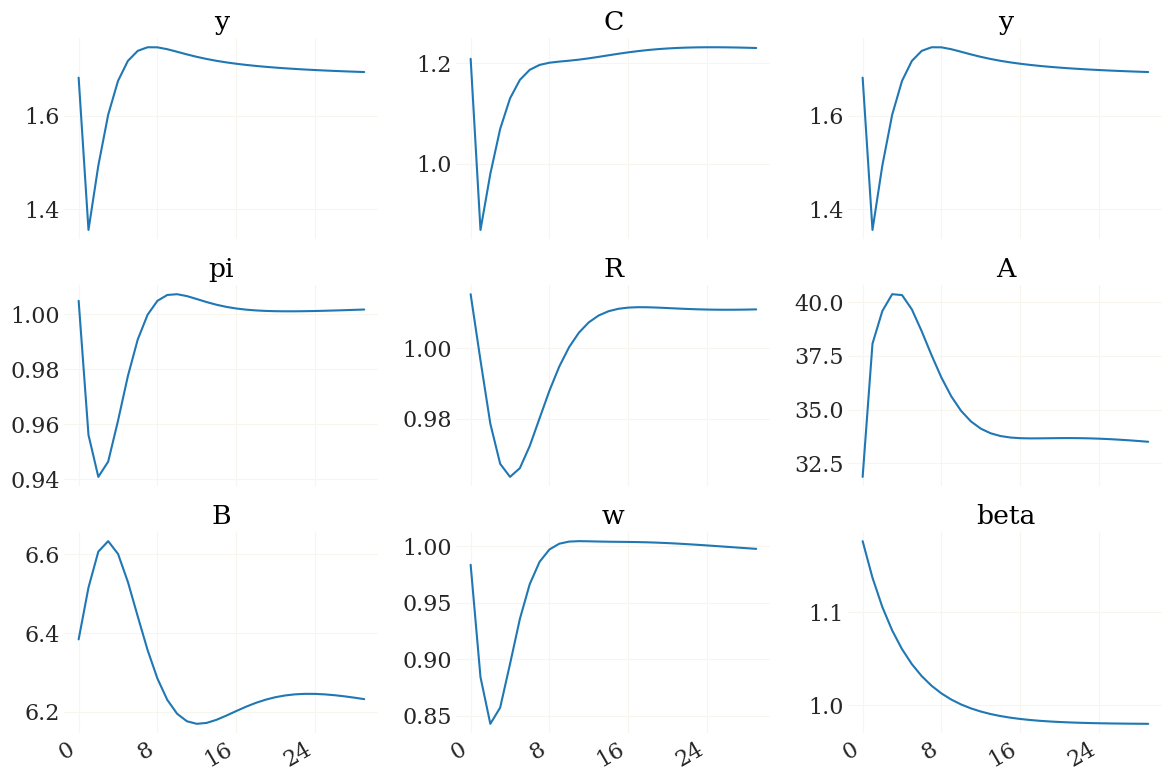

In [6]:
variables = 'y', 'C', 'y', 'pi', 'R', 'A', 'B', 'w', 'beta'
inds = [hank2['variables'].index(v) for v in variables] 

figs, axs = figurator(3,3, figsize=(12,8))
_ = grplot(xlin[:30, inds], labels=variables, ax=axs)

Great. Finally, we can compare this with the fully nonlinear responses:

In [7]:
xst, flags = hank2.find_path(init_state=x0.values())

    Iteration  1 | fev.   1 | error 7.96e+00 | inner 8.48e-06 | dampening 1.000
    Iteration  2 | fev.  24 | error 3.93e+00 | inner 7.62e-06 | dampening 1.000
    Iteration  3 | fev.  39 | error 8.56e-01 | inner 8.66e-06 | dampening 1.000
    Iteration  4 | fev.  55 | error 1.02e-01 | inner 7.23e-06 | dampening 1.000
    Iteration  5 | fev.  61 | error 1.12e-03 | inner 4.00e-06 | dampening 1.000
    Iteration  6 | fev.  63 | error 1.42e-05 | inner 5.86e-07 | dampening 1.000
    Iteration  7 | fev.  68 | error 1.70e-06 | inner 5.48e-08 | dampening 1.000
    Iteration  8 | fev.  73 | error 4.43e-08 | inner 3.71e-09 | dampening 1.000
    Iteration  9 | fev.  79 | error 1.71e-09 | inner 8.57e-11 | dampening 1.000 | lapsed 3.9128s
(find_path:) Stacking done (20.452s). The solution converged.


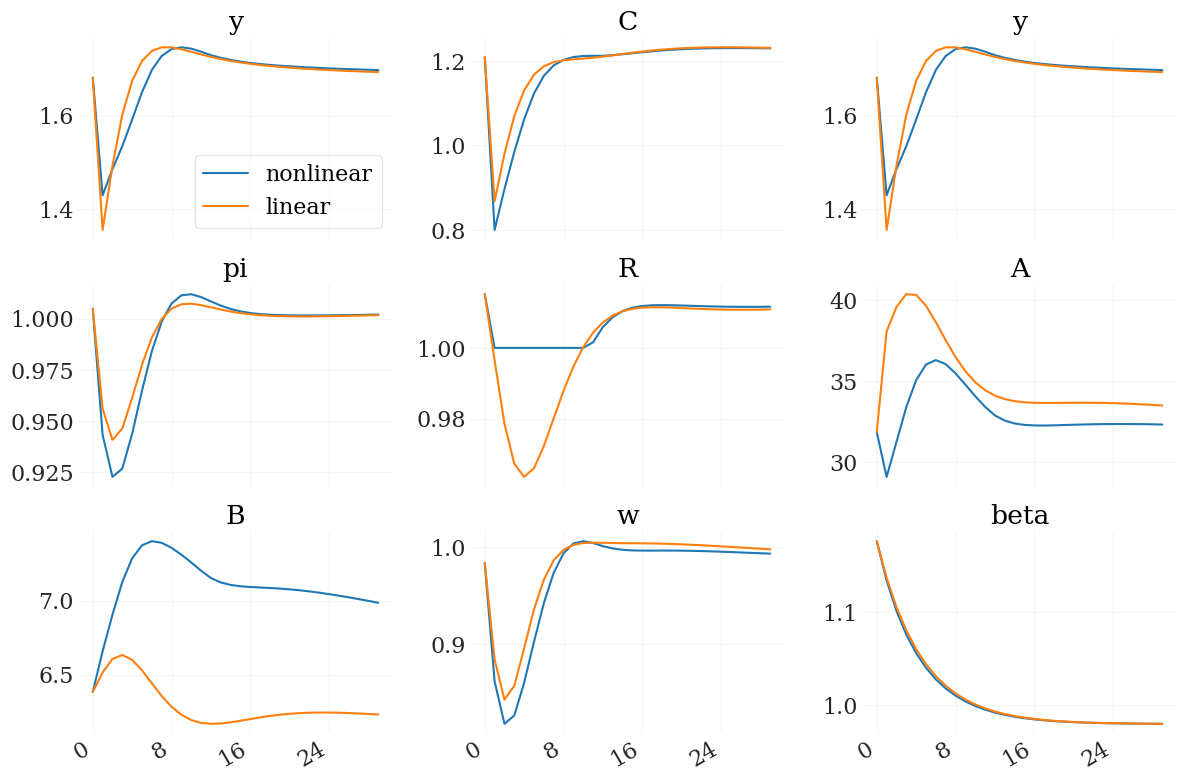

In [8]:
figs, axs = figurator(3,3, figsize=(12,8))
_ = grplot((xst[:30, inds], xlin[:30, inds]), labels=variables, ax=axs, legend=('nonlinear', 'linear'))
_ = axs[0].legend(fontsize=16)